In [1]:
import networkx as nx
from minizinc import Instance, Model, Solver
import os

In [2]:
async def run_instance_async(data_file, solver_name, other_params={}, do_print=True):
  params = {'MaxPeriod_c': 1200}
  # override default params with other_params
  for param, v in other_params.items():
    params[param] = v
  model = Model("modelFiles/wallace-hoist_cpaior20-submission.mzn")
  # Get the model/data files
  model.add_file(data_file)
  # Add params to model
  for param, v in params.items():
    model[param] = v
  solver = Solver.lookup(solver_name)
  instance = Instance(solver, model)
  result = await instance.solve_async(intermediate_solutions=True)
  if len(result) == 0:
    print("Warning no results found")
    return -1
  return result[len(result) - 1].objective, result.statistics["solveTime"]

In [29]:
# from runMiniZinc import run_instance_async
# Cannot call asyncio.run in notebook. So we await the async method here

DATA_FOLDER = "data/dzn/"
files = os.listdir(DATA_FOLDER)
objs = []
secs = []
f = files[0]

obj, sec = await run_instance_async(DATA_FOLDER+f, "gurobi", {'MaxPeriod_c': 9999999}, do_print=False)
print(obj, sec)

obj, sec = await run_instance_async(DATA_FOLDER+f, "gurobi", {'MaxPeriod_c': 160}, do_print=False)
print(obj, sec)


/home/gijs/code_projects/AIDM-CHSP/venv/lib/python3.8/site-packages/minizinc/json.py:91: MiniZincWarning: file "PU.dzn" included from library, but also exists in current working directory.
  warnings.warn(obj["message"], MiniZincWarning)
/home/gijs/code_projects/AIDM-CHSP/venv/lib/python3.8/site-packages/minizinc/json.py:91: MiniZincWarning: variable `k` shadows variable with the same name in line 86.66
  warnings.warn(obj["message"], MiniZincWarning)


CancelledError: 

In [ ]:
from concurrent.futures import ProcessPoolExecutor
import asyncio
import numpy as np

# computing outputs and save to file
DATA_FOLDER = "data/dzn/"
files = list(filter(lambda f: f.endswith('dzn'), os.listdir(DATA_FOLDER)))
objs = []
secs = []
def run(f):
  return asyncio.run(run_instance_async(DATA_FOLDER+f, "gecode"))

loop = asyncio.get_event_loop()
p = ProcessPoolExecutor(8)
loops = []
for f in files:
  loops.append(loop.run_in_executor(p, run, f))
dnz_output_file = 'data/solved/dzn_output1000.npy'
for l in loops:
   ret = await l
   obj, sec = ret if ret != -1 else (-1,-1)
   objs.append(obj)
   secs.append(sec)
   print(objs)
   np.save(dnz_output_file, {'obj':objs, 'sec':secs})

In [6]:
# dnz_output_file = 'data/solved/dzn_output.npy'
# dnz_output_file = 'data/solved/dzn_output.npy'
# multiplier 1
# hoists [1, 1, 1, 1]
# removal times [0, 170, 183, 246]
# sorted removal times [0, 170, 183, 246]
# period 343
# B [0, 1, 0]
# jobs 1
# Duration: 1.249 seconds
# Solver: gecode
import os
import numpy as np

DATA_FOLDER = "chsp-generators-main/instances/linear_solutions/"
files = os.listdir(DATA_FOLDER)
for f in files:
  if f.endswith('npy'):
    print(np.load(DATA_FOLDER+f, allow_pickle=True))
# np.save('data')

{'objective': 7479, 'r': [0, 523, 553, 3232, 20, 3259], 'p': 7479, 'hoist': [1, 1, 1, 1, 1, 1], 'B': [0, 1, 0, 1, 0]}


In [15]:


def get_params_of_file(file, folder=DATA_FOLDER):
  params = {}
  with open(folder+file) as f:
    print('t', file)
    for line in f:
      split = line.split()
      param, val = split[0], split[2][:-1]
      params[param] = int(val)
  return params
# Save params to numpy file
param_list = []
for f in files:
  param_list.append(get_params_of_file(f))
np.save('data/dzn/dzn.npy', param_list)

t 1-4-1.dzn
t 2-1-1.dzn
t 2-3-2.dzn
t 2-2-1.dzn
t 3-1-1.dzn
t 2-3-1.dzn
t 1-2-1.dzn
t 1-2-2.dzn
t 2-2-3.dzn
t 1-5-1.dzn
t 1-3-2.dzn
t 1-1-1.dzn
t 2-4-1.dzn
t 2-3-3.dzn
t 2-2-2.dzn
t 1-3-1.dzn


In [4]:
from imitation_learning.train import load_graph_data
path = './chsp-generators-main/instances/linear_solutions.npy'
training, test = load_graph_data(path)

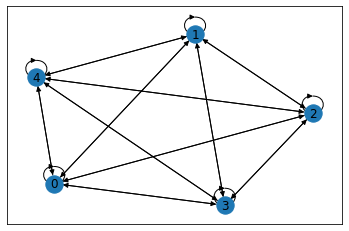

In [13]:
import networkx as nx
g_x = training[0][0].to_networkx()
nx.draw_networkx(g_x)